In [45]:
from typing import TypedDict
from langchain.tools import tool
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
import json, os
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI
load_dotenv()

True

In [46]:
# llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash", temperature=0)
llm = ChatOpenAI(
    api_key = os.getenv("OPENROUTER_API_KEY"),
    base_url = "https://openrouter.ai/api/v1",
    model = "google/gemini-2.5-flash",
    max_completion_tokens=500
)

In [47]:
from langsmith import Client

client = Client()

In [48]:
import requests
from langchain_core.tools import tool
from typing import Optional
import os, requests

@tool
def menu_tool(
    search: Optional[str] = None,
    type: Optional[str] = None,
    price_min: Optional[float] = None,
    price_max: Optional[float] = None,
) -> dict:
    """
    Retrieves restaurant menu items based on the provided criteria.

    Args:
        search (str | None): Dish name or keyword to search for.
        type (str | None): "veg" or "nonveg" to filter dish type.
        price_min (float | None): Minimum price filter.
        price_max (float | None): Maximum price filter.

    Returns:
        dict: Dictionary containing matching menu items
    """
    base_url = os.getenv("BASE_URL")
    params = {
        "search": search,
        "type": type,
        "price_min": price_min,
        "price_max": price_max
    }

    try:
        response = requests.get(base_url, params=params, timeout=10)
        response.raise_for_status()
        return response.json()
    except requests.exceptions.RequestException as e:
        print(f"Error calling backend: {e}")
        return {"error": str(e)}


@tool
def kb_tool(query:str) -> str:
    """
    Retrieves restaurant knowledge base information based on a user query.

    Args:
        query (str): Question or topic related to restaurant policies, FAQs, or general info.

    Returns:
        str: Retreived info
    """
    return "Lumina Bistro is a restaurant located at Jhamsikhel, Lalitpur."

In [49]:
tools = [menu_tool, kb_tool]

llm_with_tools = llm.bind_tools(tools)

tools_node = ToolNode(tools=tools)

In [50]:
from typing import TypedDict, Annotated, List, Optional
from langgraph.graph.message import add_messages
from langchain.schema import BaseMessage

class State(TypedDict):
    messages: Annotated[List[BaseMessage], add_messages]
    review_decision: Optional[str]
    summary: Optional[str]

In [51]:
SYSTEM_PROMPT = """SYSTEM:
You are a restaurant assistant agent. You have access to the following tools:

1. menu_tool
   Description: Returns menu items based on the following input parameters.
   Inputs:
     - search (string | null): Dish or keyword to search
     - type (string | "veg"/"non-veg"/null): Dish type
     - price_min (number | null): Minimum price
     - price_max (number | null): Maximum price
   Output: JSON object with matching menu items

2. kb_tool
   Description: Answers general knowledge questions about the restaurant.
   Inputs:
     - query (string): The question or topic
   Output: JSON object containing the answer

Your responsibilities:
- Read the user's message and your current memory (tasks + entities + messages)
- Decide which tool(s), if any, need to be called. Only call a tool if the required info is missing or outdated.
- Extract all required inputs for the tools from the user query and memory.
- Update the state: tasks, entities, and messages.
- Generate a concise response to the user using available tool results or memory.
- If slots are missing, ask the user for clarification instead of calling the tool.
- If the menu tool output provides more than 10 items then summarise them into categories like appetisers, momo, pizza etc and ask user for any specific preference.

Instructions for output:
Respond with a JSON object with the following keys:

{
  "tool_calls": [
    {
      "tool_name": "menu_tool" | "kb_tool",
      "inputs": { ... }  # filled input parameters
    }
  ],
  "answer": "string",         # final assistant message
  "updated_memory": {         # updated state to store
    "tasks": [...],
    "entities": {...}
  }
}

Rules:
- Do not hallucinate: only use memory or tool results.
- Reuse previous results if the same task with same slots is already done.
- If the user's request cannot be answered with existing memory and tool info, politely ask for clarification.
- Be concise (1-3 sentences) in your answers.
"""

In [60]:
from langchain.schema import SystemMessage, HumanMessage, AIMessage

def classify_intent(state: State):
    """
    Node to classify user intent using the LLM with tools.
    Updates state['messages'] and state['summary'] in-place.
    """
    # ensure summary exists
    state.setdefault("summary", "")

    # prepend system prompt to conversation
    messages = [SystemMessage(content=SYSTEM_PROMPT)] + state["messages"]

    # call LLM with tools
    resp = llm_with_tools.invoke(messages)

    # append AIMessage content to summary
    if isinstance(resp, AIMessage) and getattr(resp, "content", ""):
        state["summary"] += f"\nAI: {resp.content}"

    # append response to messages
    state["messages"].append(resp)

    # return minimal dict; state is already updated
    return {"messages": [resp]}


In [99]:
import json
from collections import defaultdict

def compact_menu_summary(tool_content, max_items_shown=7):
    """
    Summarize menu_tool JSON output:
    - If <= max_items_shown, return raw content.
    - If > max_items_shown, group by category and list names.
    Returns (summary_text, overflow_flag)
    """
    try:
        items = json.loads(tool_content)
    except Exception:
        return tool_content, False  # fallback

    total_items = len(items)
    
    if total_items <= max_items_shown:
        return tool_content, False  # small, keep as-is

    # group by category
    grouped = defaultdict(list)
    for item in items:
        cat = item.get("category_name") or "Other"
        grouped[cat].append(item.get("name", "item"))

    summary_lines = [f"{cat}: {', '.join(names)}" for cat, names in grouped.items()]
    summary_lines.append("Above is the data received from menu_tool call applying user's preferences.")
    return "\n".join(summary_lines), True


In [ ]:
def tool_summarizer_node(state):
    """
    Summarizes tool messages and appends to state['summary'].
    Detects tool messages dynamically by checking for 'name' and 'content' attributes.
    """
    state.setdefault("summary", "")

    for msg in state.get("messages", []):
        # dynamically detect tool messages
        if not hasattr(msg, "name") or not hasattr(msg, "content"):
            continue

        content = msg.content
        name = msg.name
        if not content or not name:
            continue

        if name == "menu_tool":
            summary_text, overflow = compact_menu_summary(content)
            state["summary"] += f"\nmenu_tool summary:\n{summary_text}"
        else:
            state["summary"] += f"\n{name} output:\n{content}"
        

    return {"summary": state["summary"]}


In [ ]:
from typing import Literal
from pydantic import BaseModel

reviewer_llm = llm 
class ReviewDecision(BaseModel):
    decision: Literal["ok", "needs_more"]
    rationale: str = ""
    answer: str = ""
    todo: str = ""

REVIEWER_PROMPT = """You are a restaurant assitant agent who can answer general questions about this restaurant and menu queries.
Compare the user's request with the latest tool outputs in the conversation if needed.
- If the tool output provides enough information to answer the user's query, set decision="ok" and produce a natural, concise answer to the user in the 'answer' field.
- If the tool output is incomplete or missing required details, set decision="needs_more" and explain what additional information or tool calls are needed in the 'todo' field.
- When providing an answer, summarize options clearly and include prices if provided, grouped by category if needed, so it reads like a reply to the user.

Return a JSON object with fields:
- decision: "ok" | "needs_more"
- rationale: brief reason
- answer: final user-facing answer if decision == "ok", else ""
- todo: what is still needed if decision == "needs_more"

"""

# Wrap the model to return the Pydantic object directly:
structured_reviewer = reviewer_llm.with_structured_output(ReviewDecision)

def reviewer_node(state: State):
    from langchain.schema import SystemMessage
    msgs = [SystemMessage(content=REVIEWER_PROMPT)]

    # include summary as a system message (compressed menu_tool output)
    if "summary" in state and state["summary"]:
        msgs.append(SystemMessage(content=f"Summary: {state['summary']}"))

    # Call structured reviewer
    review: ReviewDecision = structured_reviewer.invoke(msgs)
    
    updates = {}

    # Update messages with final answer or reviewer note
    if review.decision == "ok" and review.answer:
        updates["messages"] = [AIMessage(content=review.answer)]
        # Append reviewer info to summary
        state.setdefault("summary", "")
        state["summary"] += f"\nReviewer decision: OK\nRationale: {review.rationale}\nAnswer: {review.answer}"
    else:
        updates["messages"] = [SystemMessage(content=f"Reviewer: needs more info → {review.todo}")]
        # Append reviewer info to summary
        state.setdefault("summary", "")
        state["summary"] += f"\nReviewer decision: Needs more info\nRationale: {review.rationale}\nTodo: {review.todo}"

    # Always update review_decision in state
    updates["review_decision"] = review.decision
    return updates

In [127]:
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import tools_condition


def route_after_reviewer(state: State):
    return "intent_node" if state.get("review_decision") == "needs_more" else "__end__"

def build_graph():
    g = StateGraph(State)

    g.add_node("intent_node", classify_intent)
    g.add_node("tools", tools_node)          # or tools_node.invoke
    g.add_node("reviewer", reviewer_node)
    g.add_node("summarize_menu_tool",tool_summarizer_node)

    g.add_edge(START, "intent_node")

    # If assistant asked for tools, go to tools; otherwise go to reviewer
    g.add_conditional_edges(
        "intent_node",
        tools_condition,
        {"tools": "tools", "__end__": "reviewer"},
    )

    g.add_edge("tools", "summarize_menu_tool")

    g.add_edge("summarize_menu_tool", "reviewer")

    # Reviewer decides whether to loop back or end
    g.add_conditional_edges(
        "reviewer",
        route_after_reviewer,
        {"intent_node": "intent_node", "__end__": END},
    )

    return g.compile()


In [128]:
graph = build_graph()


In [129]:
from langchain.schema import HumanMessage

# user query
user_input = "where are you located and do you serve anything sweet"
human_msg = HumanMessage(content=user_input)

# ensure state exists
state = {
    "messages": [],
    "summary": ""
}

# append human message to messages and summary
state["messages"].append(human_msg)
state["summary"] += f"\nHuman: {human_msg.content}"

# now invoke your graph with updated state
result = graph.invoke(state)


'SUMMARY AFTER SUMMARIZER:'

'\nHuman: where are you located and do you serve anything sweet\nkb_tool output:\nLumina Bistro is a restaurant located at Jhamsikhel, Lalitpur.\nmenu_tool summary:\n[{"category_id": 8, "subcategory": "Veg", "name": "Brownie", "description": "A rich, chocolatey brownie, available with or without a scoop of ice cream.", "is_available": true, "id": 46, "variations": [{"item_id": 46, "label": "With Ice Cream", "final_price": "300.00", "is_available": true, "id": 62}, {"item_id": 46, "label": "Without Ice Cream", "final_price": "240.00", "is_available": true, "id": 63}], "category_name": "Dessert"}, {"category_id": 8, "subcategory": "Veg", "name": "Juju Dhau (Bhaktapur King Yogurt)", "description": "A famous sweet yogurt from Bhaktapur, also known as the \\"King of Yogurts\\".", "is_available": true, "id": 47, "variations": [{"item_id": 47, "label": "Default", "final_price": "180.00", "is_available": true, "id": 64}], "category_name": "Dessert"}, {"category_id": 8, "subcategory": "Veg", "n

'SUMMARY RECEIVED IN REVIEWER:\n'

'\nHuman: where are you located and do you serve anything sweet\nkb_tool output:\nLumina Bistro is a restaurant located at Jhamsikhel, Lalitpur.\nmenu_tool summary:\n[{"category_id": 8, "subcategory": "Veg", "name": "Brownie", "description": "A rich, chocolatey brownie, available with or without a scoop of ice cream.", "is_available": true, "id": 46, "variations": [{"item_id": 46, "label": "With Ice Cream", "final_price": "300.00", "is_available": true, "id": 62}, {"item_id": 46, "label": "Without Ice Cream", "final_price": "240.00", "is_available": true, "id": 63}], "category_name": "Dessert"}, {"category_id": 8, "subcategory": "Veg", "name": "Juju Dhau (Bhaktapur King Yogurt)", "description": "A famous sweet yogurt from Bhaktapur, also known as the \\"King of Yogurts\\".", "is_available": true, "id": 47, "variations": [{"item_id": 47, "label": "Default", "final_price": "180.00", "is_available": true, "id": 64}], "category_name": "Dessert"}, {"category_id": 8, "subcategory": "Veg", "n

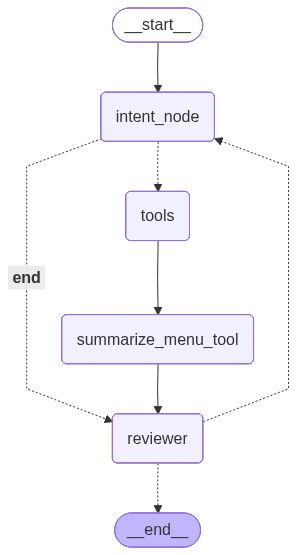

In [125]:
build_graph()

In [130]:
result

{'messages': [HumanMessage(content='where are you located and do you serve anything sweet', additional_kwargs={}, response_metadata={}, id='fb831bc4-d274-4256-8749-5d3c2efc6269'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'tool_0_kb_tool_ntcbSnUXmeKgUI9sdRFM', 'function': {'arguments': '{"query":"Our location"}', 'name': 'kb_tool'}, 'type': 'function', 'index': 0}, {'id': 'tool_1_menu_tool_sjK0wq5UATj2IQqd48mE', 'function': {'arguments': '{"search":"dessert"}', 'name': 'menu_tool'}, 'type': 'function', 'index': 1}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 11, 'prompt_tokens': 665, 'total_tokens': 676, 'completion_tokens_details': {'accepted_prediction_tokens': None, 'audio_tokens': None, 'reasoning_tokens': 0, 'rejected_prediction_tokens': None, 'image_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 0}}, 'model_name': 'google/gemini-2.5-flash', 'system_fingerprint': None, 'id': 'gen-1761591181-zX41up